# Transformation from/to IR

## Poles

┌ Warning: PyPlot is using tkagg backend, which is known to cause crashes on MacOS (#410); use the MPLBACKEND environment variable to request a different backend.
└ @ PyPlot /Users/hiroshi/.julia/packages/PyPlot/XaELc/src/init.jl:198


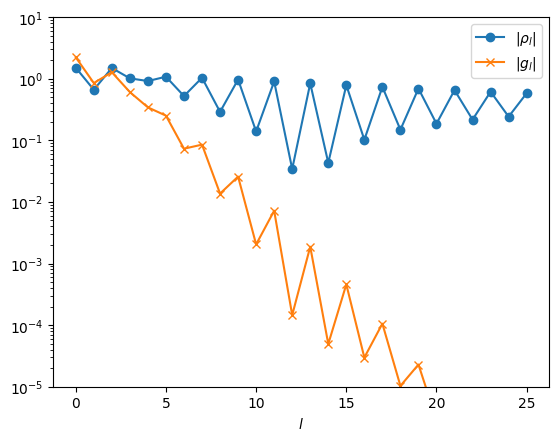

In [1]:
using SparseIR
#ENV["MPLBACKEND"]="tkagg"
using PyPlot
using OMEinsum


beta = 15.0
wmax = 10.0
basis_b = FiniteTempBasis(boson, beta, wmax, 1e-7)

coeff = [1.0]
omega_p = [0.1]

rhol_pole = ein"lp,p->l"(
    basis_b.v(omega_p),
    coeff ./ tanh.(0.5*beta*omega_p)
)
gl_pole = - basis_b.s .* rhol_pole

plt.semilogy(abs.(rhol_pole), marker="o", label=L"|\rho_l|")
plt.semilogy(abs.(gl_pole), marker="x", label=L"|g_l|")

plt.xlabel(L"$l$")
plt.ylim([1e-5, 1e+1])
plt.legend()
;

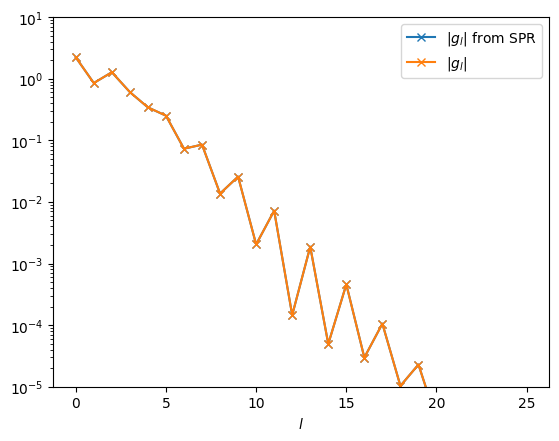

In [2]:
sp = SparsePoleRepresentation(basis_b, omega_p)
gl_pole2 = to_IR(sp, coeff)

plt.semilogy(abs.(gl_pole2), marker="x", label=L"$|g_l|$ from SPR")
plt.semilogy(abs.(gl_pole), marker="x", label=L"$|g_l|$")

plt.xlabel(L"$l$")
plt.ylim([1e-5, 1e+1])
plt.legend()
#plt.show()
;

## From smooth spectral function

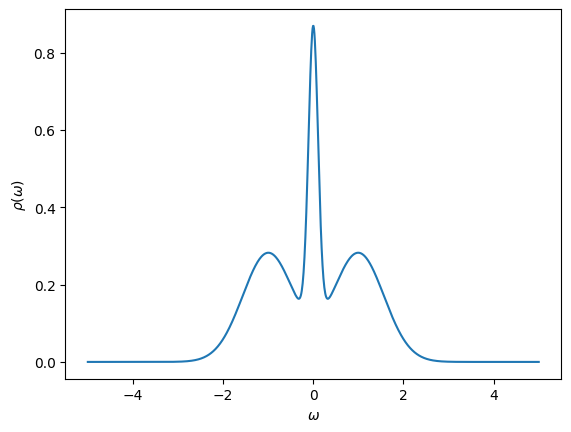

In [3]:
# Three Gaussian peaks (normalized to 1)
gaussian(x, mu, sigma) = exp(-((x-mu)/sigma)^2)/(sqrt(π)*sigma)

rho(omega) = 0.2*gaussian(omega, 0.0, 0.15) + 
    0.4*gaussian(omega, 1.0, 0.8) + 0.4*gaussian(omega, -1.0, 0.8)

omegas = LinRange(-5, 5, 1000)
plt.xlabel(L"\omega")
plt.ylabel(L"\rho(\omega)")
plt.plot(omegas, rho.(omegas))
#plt.show()
;
;

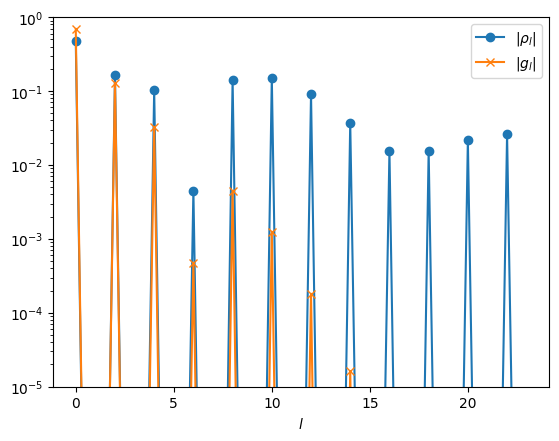

In [4]:
beta = 10.0
wmax = 10.0
basis = FiniteTempBasis(fermion, beta, wmax, 1e-7)

rhol = [overlap(basis.v[l], rho) for l in 1:length(basis)]
gl = - basis.s .* rhol

plt.semilogy(abs.(rhol), marker="o", label=L"|\rho_l|")
plt.semilogy(abs.(gl), marker="x", label=L"|g_l|")
plt.xlabel(L"l")
plt.ylim([1e-5, 1])
plt.legend()
#plt.show()
;

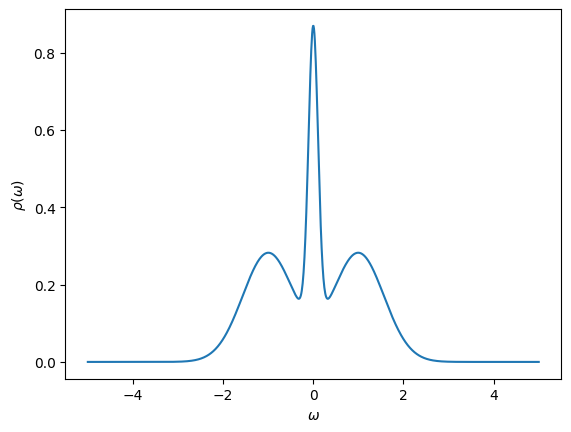

In [5]:
rho_omgea_reconst = transpose(basis.v(omegas)) * rhol

plt.xlabel(L"\omega")
plt.ylabel(L"\rho(\omega)")
plt.plot(omegas, rho.(omegas))
#plt.show()
;

## From IR to imaginary time

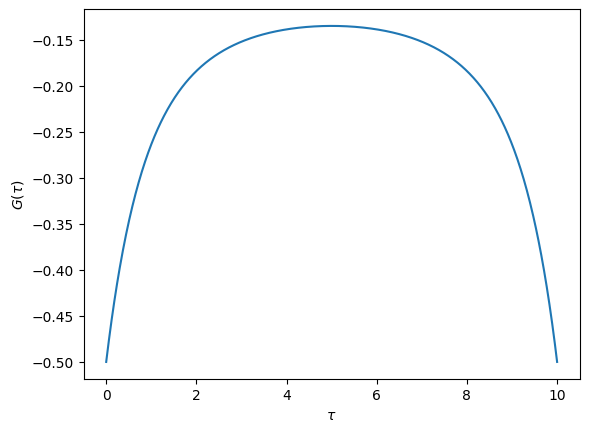

In [6]:
taus = collect(LinRange(0, beta, 1000))
gtau1 = transpose(basis.u(taus)) * gl
plt.plot(taus, gtau1)
plt.xlabel(L"\tau")
plt.ylabel(L"G(\tau)")
#plt.show()
;

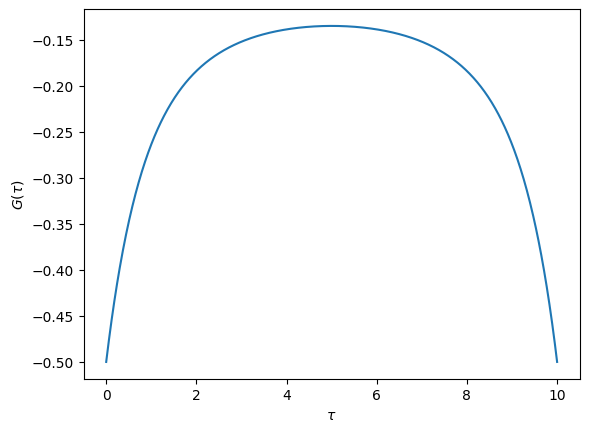

In [7]:
smpl = TauSampling(basis, taus)
gtau2 = evaluate(smpl, gl)
plt.plot(taus, gtau1)
plt.xlabel(L"\tau")
plt.ylabel(L"G(\tau)")
#plt.show()
;

## From full imaginary-time data

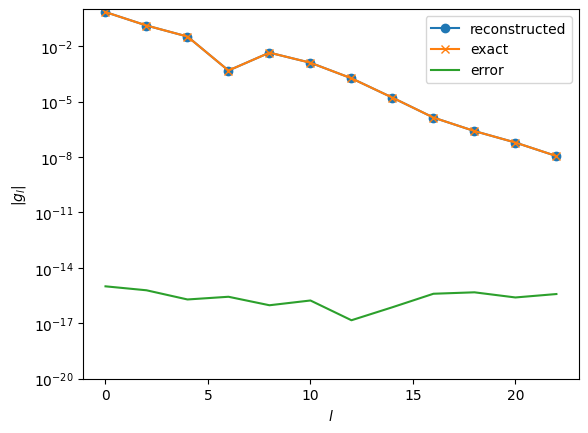

In [8]:
function eval_gtau(taus)
    uval = basis.u(taus) #(nl, ntau)
    return transpose(uval) * gl
end

gl_reconst = [overlap(basis.u[l], eval_gtau) for l in 1:length(basis)]

ls = collect(0:length(basis)-1)
plt.semilogy(ls[1:2:end], abs.(gl_reconst[1:2:end]), label="reconstructed", marker="o")
plt.semilogy(ls[1:2:end], abs.(gl[1:2:end]), label="exact", marker="x")
plt.semilogy(ls[1:2:end], abs.(gl_reconst - gl)[1:2:end], label="error", marker="")
plt.xlabel(L"l")
plt.ylabel(L"|g_l|")
plt.ylim([1e-20, 1])
plt.legend()
#plt.show()
;